In [ ]:
import numpy as np
import pandas as pd
import numpy.random
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [ ]:
df = pd.read_csv('../hackerrank_data/shots.csv')
df = df[df.shot_y<=40]
print df.info()

In [ ]:
heatmap, xedges, yedges = np.histogram2d(df.shot_x, df.shot_y, bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
ax.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

In [ ]:
bin_num = 20

d = stats.binned_statistic_2d(df.shot_x, df.shot_y, df.made, statistic='count', bins=bin_num)
d = np.array([np.where(np.array(d[0])>40, np.array(d[0]), 0), np.array(d[1]), np.array(d[2])])

extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(d[0].T, cmap='RdBu_r', extent=extent, interpolation='nearest', origin='lower')

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('shooting percentage')
plt.show()

In [ ]:
bin_num = 40
min_obs = 3
# bin_num = 20
# min_obs = 30

d_mean = stats.binned_statistic_2d(df.shot_x, df.shot_y, df.made, statistic='mean', bins=bin_num)
d_count = stats.binned_statistic_2d(df.shot_x, df.shot_y, df.made, statistic='count', bins=bin_num)
d = np.array([np.where(np.array(d_count[0])>min_obs, np.array(d_mean[0]), np.nan), np.array(d_mean[1]), np.array(d_mean[2])])

extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(d[0].T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') # RdBu_r

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('shooting percentage')

plt.savefig('shooting_percentage.png')
plt.show()

Is there a significant difference in the shooting percentage between the top of the key and the wings?
* Test this...two-sample difference in means

Why might this be?
* Worse shooters
* Farther away
* Defense structure
* Better defense
* Worse offensive techniques

In [ ]:
# bin_num = 40
# min_obs = 5
bin_num = 20
min_obs = 30

var = df.defender_distance
# defender_distance
# defender_velocity_ft_sec
# defender_angle
# shooter_velocity_ft_sec
# shooter_velocity_angle
# dribbles_before

d_mean = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='mean', bins=bin_num)
d_count = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='count', bins=bin_num)
d = np.array([np.where(np.array(d_count[0])>min_obs, np.array(d_mean[0]), np.nan), np.array(d_mean[1]), np.array(d_mean[2])])

extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
im = ax.imshow(d[0].T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') # RdBu_r

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('shooting percentage')

plt.savefig('shooting_percentage.png')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
df = df[((np.sqrt(df.shot_y**2 + df.shot_x**2)>=23.75) & (np.sqrt(df.shot_y**2 + df.shot_x**2)<26.75)) | ((np.abs(df.shot_x)>=22) & (df.shot_y<(14-4-.75)))]
# X = df[['shooter_velocity_ft_sec', 'shooter_velocity_angle', 'dribbles_before', 'defender_distance', 'defender_angle', 'defender_velocity_ft_sec', 'defender_velocity_angle']]
X = df[['shot_x', 'shot_y']]

kmean_score = []
for i in xrange(2, 10):
    kmean = KMeans(n_clusters = i).fit(X) #random_state = 2
    kmean_score.append(-kmean.score(X))

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1,1,1)
ax.plot(range(2, 10), kmean_score, marker='o')
plt.show()


In [ ]:
kmean4 = KMeans(n_clusters = 4, random_state = 2).fit_predict(X)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(df.shot_x, df.shot_y, c = kmean4)
plt.show()

# kmean5 = KMeans(n_clusters = 5, random_state = 2).fit(X)

In [ ]:
kmean5 = KMeans(n_clusters = 5, random_state = 2).fit_predict(X)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(df.shot_x, df.shot_y, c = kmean5)
plt.show()

In [ ]:
# if you control for distance from the hoop, distance of the defender, number of dribbles (or just if it is greater than 0?), 
# velocity of shooter, absolute value of angle of the shooter, ..the other ones too.
# are there group specific effects?

from statsmodels.discrete.discrete_model import Logit

X = pd.get_dummies(kmean5, drop_first=False)
X['ones'] = 1
distance = np.sqrt(df.shot_x.values**2 + df.shot_y.values**2)
X = pd.concat([X,pd.DataFrame(distance)], axis=1)
X.drop(1, 1, inplace=True)

# print kmean5[0:10]
# print df
# print pd.DataFrame(df.made.values)
logit = Logit(pd.DataFrame(df.made.values), X).fit()
print logit.summary()


From the coefficient on the constant, we see that the probability of making a shot from this location (left wing) is around .3 (odds of .42). This means the odds of making a shot from location 4 (right corner) is (exp(0.3421)-1)*100 (about 41) percent higher than in location 0.

In [ ]:
from statsmodels.discrete.discrete_model import Logit
from sklearn.cluster import KMeans
df = pd.read_csv('../hackerrank_data/shots.csv')

df = df[((np.sqrt(df.shot_y**2 + df.shot_x**2)>=22) & (np.sqrt(df.shot_y**2 + df.shot_x**2)<25))]
# X = df[['shooter_velocity_ft_sec', 'shooter_velocity_angle', 'dribbles_before', 'defender_distance', 'defender_angle', 'defender_velocity_ft_sec', 'defender_velocity_angle']]
X = df[['shot_x', 'shot_y']]

kmean5 = KMeans(n_clusters = 5, random_state = 2).fit_predict(X)

fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(1,1,1)
ax.scatter(df.shot_x, df.shot_y, c = kmean5)
plt.show()

X = pd.get_dummies(kmean5, drop_first=False)
X['ones'] = 1

df['three_pointer'] = 0
df.ix[((np.sqrt(df.shot_y**2 + df.shot_x**2)>=23.75) | ((np.abs(df.shot_x)>=22) & (df.shot_y<(14-4-.75)))), 'three_pointer'] = 1 

X = pd.concat([X,pd.DataFrame(df.three_pointer.values)], axis=1)
X.drop(1, 1, inplace=True)

# print kmean5[0:10]
# print df
# print pd.DataFrame(df.made.values)
logit = Logit(pd.DataFrame(df.made.values), X).fit()
print logit.summary()

In [ ]:
# do 4! pairwise t-tests of proportions to determine if there is signficant differences between these groups in terms of shooting percentage


In [ ]:
# bin_num = 30 
# min_obs = 0
# bin_num = 25
# min_obs = 5

# d_mean = stats.binned_statistic_2d(df.shot_x, df.shot_y, df.made, statistic='mean', bins=bin_num)
# d_count = stats.binned_statistic_2d(df.shot_x, df.shot_y, df.made, statistic='count', bins=bin_num)
# d = np.array([np.where(np.array(d_count[0])>min_obs, np.array(d_mean[0]), np.nan), np.array(d_mean[1]), np.array(d_mean[2])])

# extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
# fig = plt.figure(figsize=(18,8))
# ax = fig.add_subplot(1,1,1)
# im = ax.imshow(d[0].T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') # RdBu_r

# cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
# cb = plt.colorbar(im, cax=cbar_ax)
# cb.set_label('shooting percentage')

# plt.savefig('shooting_percentage.png')
# plt.show()

* Do some unsupervised learning action on these spots to see if there are some important differences between them.

* often defenders play off a little bit the farther out shooters get...can this be exploited for gain? In other words, while these are lower percentage shots, maybe the extra sag increases the percentages enough. If the defense starts expanding to cover it, then a strategic response is moving the ball inside.
    * estimate the effect of distance on shooting percentage---assuming a linear effect (?)---for the subsample of "normal" shots
        * control for whether its a three point shot (defenses might behave differently in a non-linear way)
    * estimate the effect of distance on shooting percentage
    
    
* estimate the effect of distance from the basket on the distance to the shooter
* estimate the effect of distance from the basket on shooting percentage
* estimate the effect of distance to the shooter on shooting percentage



What is the expected number of points from "normal" offensive sets (call this value x)? Is there a distance in the "hyper" range such that the expected number of points from a shot there is greater than x?

- Show that, as expected, the probability of a make falls with distance from hoop, increases with distance from the defender and that the distance of a defender increases with the distance from the basket.
- Make argument
- What else would I need to know and/or do in order for the project to be complete

An econometrician at UC Berkley (or San Diego) a decade and a half (or so) ago ... This type of anaylsis may be perceived as ridiculous in the eyes of NBA practiioners, but I think it may have statistical merit (but certainly would need further analysis). Spacing is a vital to succesfful modern NBA offenses. However, constraints to greater spacing are the dimensions of the court, the three-point line? (expected number of points when the ball is farther from the basket). Regarding the latter, the expected number of points are less because (1) the ball is actually shot from farther distances less, and (2) when the ball is shot, the probability it goes in is smaller. 


Shooting percentages from hyper-distance will go up as shooters diligently practice from that range. 

In [ ]:
df = df[df.shot_y<=40]

fig = plt.figure(figsize=(7.5,9))
ax = fig.add_subplot(1,1,1)
im = ax.hexbin(df.shot_x, df.shot_y, gridsize=25, cmap=CM.jet, bins=None)

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('frequency')
plt.show()

In [ ]:
df = df[df.shot_y<=40]

fig = plt.figure(figsize=(7.5,9))
ax = fig.add_subplot(1,1,1)
im = ax.hexbin(df.shot_x, df.shot_y, C=df.made, gridsize=25, cmap=CM.jet, bins=None, reduce_C_function = np.mean)

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('mean value')
plt.show()

In [ ]:


df = df[df.shot_y<=40]

fig = plt.figure(figsize=(7.5,9))
ax = fig.add_subplot(1,1,1)
num_arr = np.where(ax.hexbin(df.shot_x, df.shot_y, gridsize=25, cmap=CM.jet, bins=None).get_array()>=50, 1, 0)

plt.cla()
ax = fig.add_subplot(1,1,1)
im = ax.hexbin(df.shot_x, df.shot_y, C=df.made, gridsize=25, cmap=CM.jet, bins=None, reduce_C_function = np.mean)

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('mean value')
plt.show()

Initial model:
* Features
    * distance, angle from basket, the features already in the data set. 
* make sure to tune hyperparameters using CV, and then evaluate the models using test data


How about the following:
* Predict the probability of a shot being made or not. 
* Bootstrap the distribution of the expected values given these probabilities 
    * Bootstrap the probabilities, then, given the probability, draw a make or miss
    * add the makes and create the distribution
    * evaluate the actual sum of the makes given this distribution

or

* Predict whether a shot is made or not. 
* Bootstrap the distribution of the expected values given these probabilities 
    * Bootstrap each of the predictions
    * add the makes and create the distribution
    * evaluate the actual sum of the makes given this distribution

* Plot the probabilities using a contour plot

Problems:
* What if the initial accuracy is poor? In other words, if the model is inherently bad, then the detection of the anomalies will not be very good either. 
    * Discuss why the prediction is not very good...what other variables would be nice to have?
    
What this tells us:
* Gives insights into the importance of other variables. These include things such as
    * Player idiosyncracies
    * Defense idiosyncracies
* How does it tell us anything?
    * We are comparing against the average, essentially

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import percentileofscore
from sklearn.grid_search import GridSearchCV
from sklearn.metrics.scorer import make_scorer
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import ElasticNet, Ridge, Lasso
%matplotlib inline

In [24]:
df = pd.read_csv('../hackerrank_data/shots.csv')
df = df[(np.sqrt(df.shot_y**2 + df.shot_x**2)<26.75)] # restrict data to "normal" shots (i.e., within 26'9'')

column_names = df.columns
df = pd.DataFrame(df.values, columns = column_names) # reset dataframe index


#feature engineering, define feature and outcome matrix
df['three_pointer'] = 0
df.ix[(np.sqrt(df.shot_y**2 + df.shot_x**2)>=23.75) | ((np.abs(df.shot_x)>=22) & (df.shot_y<(14-4-.75))), 'three_pointer'] = 1

df['degrees'] = np.degrees(np.arccos(((df.shot_x*0 + df.shot_y*1) / np.sqrt(df.shot_x**2 + df.shot_y**2))))
df['distance'] = np.sqrt(df.shot_x**2 + df.shot_y**2)
X = df.copy()

X['shooter_velocity_angle'] = np.abs(X['shooter_velocity_angle'])
X['defender_angle'] = np.abs(X['defender_angle'])
X['defender_velocity_angle'] = np.abs(X['defender_velocity_angle'])

X.drop(['shot_x', 'shot_y'], 1, inplace=True)

y = X.pop('made')
print df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8896 entries, 0 to 8895
Data columns (total 13 columns):
shot_x                      8896 non-null float64
shot_y                      8896 non-null float64
shooter_velocity_ft_sec     8896 non-null float64
shooter_velocity_angle      8896 non-null float64
dribbles_before             8896 non-null float64
made                        8896 non-null float64
defender_distance           8896 non-null float64
defender_angle              8896 non-null float64
defender_velocity_ft_sec    8896 non-null float64
defender_velocity_angle     8896 non-null float64
three_pointer               8896 non-null int64
degrees                     8896 non-null float64
distance                    8896 non-null float64
dtypes: float64(12), int64(1)
memory usage: 903.6 KB
None


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 0) #0 in honor of russ

In [ ]:
# def scorer(y_actual, y_pred):
#     D = np.where((y_pred==0) & (y_actual==0), 1, 0)
#     B = np.where((y_pred==0) & (y_actual==1), 1, 0)
#     return np.sum(D)/float((np.sum(D)+np.sum(B)))

In [ ]:
# gbc = GradientBoostingClassifier()

# score = make_scorer(scorer, greater_is_better=True)

# param_dict = {'learning_rate': [0.005, 0.01, 0.015, 0.02, 0.05, 0.1],
#     'n_estimators': [50, 75, 100, 500, 1000],
#     'max_features': [3, 4, 5, 6]}
# gsCV_gbc = GridSearchCV(gbc, param_dict, n_jobs = -1, scoring=score)
# gsCV_gbc.fit(X, y)

# print gsCV_gbc.best_params_
# print gsCV_gbc.best_score_


In [ ]:
# from sklearn.metrics import accuracy_score
# print accuracy_score(gsCV_gbc.predict(X), y)


In [ ]:
# lasso = Lasso(alpha = .00000001, normalize=True).fit(X, y)
# print lasso.score(X, y)

# ridge = Ridge(alpha = 0.5, normalize=True).fit(X, y)
# # 0.0980383699763
# print ridge.score(X, y)

In [25]:
en = ElasticNet(normalize=True)

# score = make_scorer(scorer, greater_is_better=True)

param_dict = {'alpha': [0.0000000001, 0.0000005, 0.0000075, 0.000001, 0.000005, 0.0001, 0.001, 0.01, 0.1, .25, .5, .75, 1],
    'l1_ratio': [0, 0.0002, .45, .475, .5, .525, .55, .95, 1]}
gsCV_en = GridSearchCV(en, param_dict, n_jobs = -1)
gsCV_en.fit(X, y)

print gsCV_en.best_params_
print gsCV_en.best_score_


{'alpha': 1e-06, 'l1_ratio': 0}
0.0723189862283


In [26]:
def boots_r(pred_prob, actual):
    sample_size = 1000

    boot_shooting_perc_dist = []
    for i in xrange(sample_size):
        boot_perc_sample = [pred_prob[ind] for ind in np.random.choice(len(pred_prob), len(pred_prob), replace=True)]
        samp_mean = np.mean(np.where(np.random.uniform(0, 1, len(pred_prob))<=boot_perc_sample, 1, 0))
        boot_shooting_perc_dist.append(samp_mean) 
    return percentileofscore(boot_shooting_perc_dist, actual, kind='weak')

In [31]:
bin_num = 30
min_obs = 15

var = gsCV_en.predict(X)

d = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='mean', bins=bin_num)
statistic, xedges, yedges, binnumber = d

binnumber = pd.Series(binnumber)

bin_max_num = binnumber.max()

stat = []
min_obs = 20
for i in xrange(len(xedges)-1):
    i_row = []
    for j in xrange(len(yedges)-1):
        bin = df[((df.shot_x>=xedges[i]) & (df.shot_x<xedges[i+1])) & ((df.shot_y>=yedges[j]) & (df.shot_y<yedges[j+1]))]
        l = len(bin)
        if l<min_obs:
            i_row.append(np.nan)
        else:
            b = boots_r(var[bin.index.values], bin.made.mean())
            if b>=95:
                i_row.append(1)
            elif b<=5:
                i_row.append(-1)
            else:
                i_row.append(0)
    stat.append(i_row)
hey = np.array(stat)

[[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan   0.   0.   0.   0.  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan   0.   0.  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan   0.  nan  nan  nan  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan   0.   0.  nan  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
   nan  nan  nan  nan  nan  nan  nan  nan  nan   0.  nan  nan  nan  nan
   nan  nan]
 [ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  

In [103]:
from matplotlib.patches import Circle, Rectangle, Arc

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
#     hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    hoop = Circle((0, 0), radius=.75, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-3, -.75), 6, -0.125, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-8, -4), 16, 19, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-6, -4), 12, 19, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 14.75), 12, 12, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 14.75), 12, 12, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 8, 8, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-22, -4), 0, 13.75, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((22, -4), 0, 13.75, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 48, 48, theta1=23.75, theta2=156.25, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-25, -4), 50, 47, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

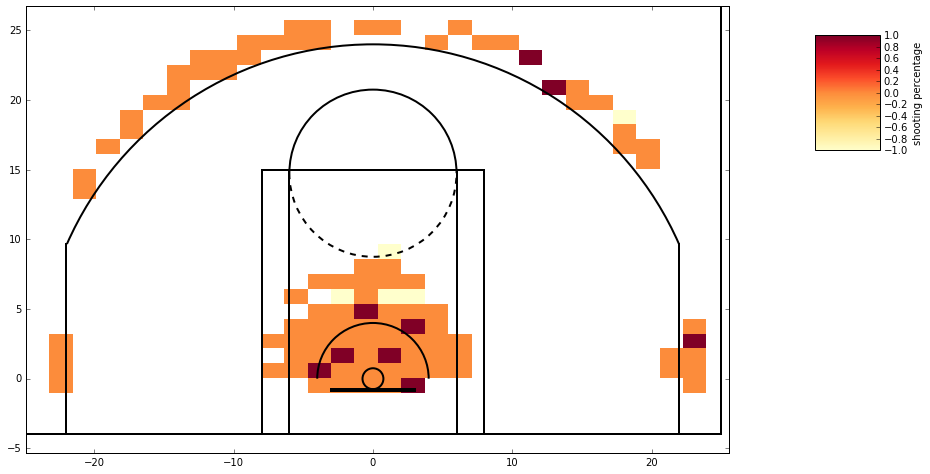

In [104]:
extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(1,1,1)
draw_court(outer_lines=True)

im = ax.imshow(hey.T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') #  

cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
cb = plt.colorbar(im, cax=cbar_ax)
cb.set_label('shooting percentage')

plt.savefig('shooting_percentage.png')
plt.show()

In [ ]:
def boots(pred, actual):
    print pred
    print actual
    sample_size = 1000
    boot_shooting_perc_dist = []
    for i in xrange(sample_size):
        samp_mean = np.mean([pred[ind] for ind in np.random.choice(len(pred), len(pred), replace=True)])
        boot_shooting_perc_dist.append(samp_mean) 
    return percentileofscore(boot_shooting_perc_dist, actual, kind='weak')    

In [ ]:
bin_num = 5
min_obs = 20

var = gsCV_gbc.predict(X)

d = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='mean', bins=bin_num)
# d = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='count', bins=bin_num)
statistic, xedges, yedges, binnumber = d

binnumber = pd.Series(binnumber)

bin_max_num = binnumber.max()

stat = []
min_obs = 20
for i in xrange(len(xedges)-1):
    i_row = []
    for j in xrange(len(yedges)-1):
        bin = df[((df.shot_x>=xedges[i]) & (df.shot_x<xedges[i+1])) & ((df.shot_y>=yedges[j]) & (df.shot_y<yedges[j+1]))]
        l = len(bin)
        if l<min_obs:
            i_row.append(np.nan)
        else:
            i_row.append(boots(var[bin.index.values], bin.made.mean()))
    print i_row
    stat.append(i_row)
    break
# print statistic
# print np.array(stat)

# d_count = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='count', bins=bin_num)
# d = np.array([np.where(np.array(d_count[0])>min_obs, np.array(d_mean[0]), np.nan), np.array(d_mean[1]), np.array(d_mean[2])])

# # d_mean = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='mean', bins=bin_num)
# # d_count = stats.binned_statistic_2d(df.shot_x, df.shot_y, var, statistic='count', bins=bin_num)
# # d = np.array([np.where(np.array(d_count[0])>min_obs, np.array(d_mean[0]), np.nan), np.array(d_mean[1]), np.array(d_mean[2])])

# hey = d[0]
# hey[0,0] = 500

# extent = [d[1][0], d[1][-1], d[2][0], d[2][-1]]
# fig = plt.figure(figsize=(18,8))
# ax = fig.add_subplot(1,1,1)
# im = ax.imshow(d[0].T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') # RdBu_r
# # im = ax.imshow(hey.T, cmap='YlOrRd', extent=extent, interpolation='nearest', origin='lower') # RdBu_r

# cbar_ax = fig.add_axes([0.85, 0.65, 0.05, 0.2])
# cb = plt.colorbar(im, cax=cbar_ax)
# cb.set_label('shooting percentage')

# plt.savefig('shooting_percentage.png')
# plt.show()

One approach is understanding things the directly affect shooting. General average good stuff. How this could help strategic decisions is obvious: on defensive do this and don't do this, etc. But idiosyncracies can go undetected. Another approach is identifying abnormalities relative to the model. In other words, does the model systematically underperform in some respects. If these reasons can be identified, then ...

What explains this abnormalities? In other words, relative to the model, why is shooting either better or worse than the model would predict in these locations.

* Perhaps are simply occurring by random chance
* Might be explained by deficincies in the model
    * for example, the model does not capture well probability a layup will go in (since the effect is linear?)
* Might be expalined by some abnormality outside of the feature space
    * a player is really good from a certain spot
    * defenses have vulernabilities in certain spots
    * our offense gets...
    
try this again with other parameter values